# Judge Disagreement & Uncertainty Analysis

## Objective
> This notebook examines where independent judges disagreed most strongly, indicating ambiguity, instability, or adversarial success.

## Key Observation:
* In DeepSeek vs GPT-5.2 debates, Gemini Pro and Kimi K2.5 disagreed on outcomes, requiring Claude Haiku 4.5 as tiebreaker. Single-judge evaluations significantly understate uncertainty.

## Judge Protocol

- Standard evaluation: 2 judges
- If disagreement exceeds threshold → third judge (tiebreaker)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [3]:
# Load Processed Results
df = pd.read_csv("sandbox_results.csv")
df.columns = df.columns.str.strip()

## Discrepancy Metric

Discrepancy = max(judge score) − min(judge score)

Higher discrepancy indicates:
* Semantic ambiguity
* Persuasive adversarial pressure
* Judge model sensitivity

/var/folders/kg/5b47027d33g7c5q5zmj879080000gs/T/ipykernel_97194/1751793338.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
/var/folders/kg/5b47027d33g7c5q5zmj879080000gs/T/ipykernel_97194/1751793338.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


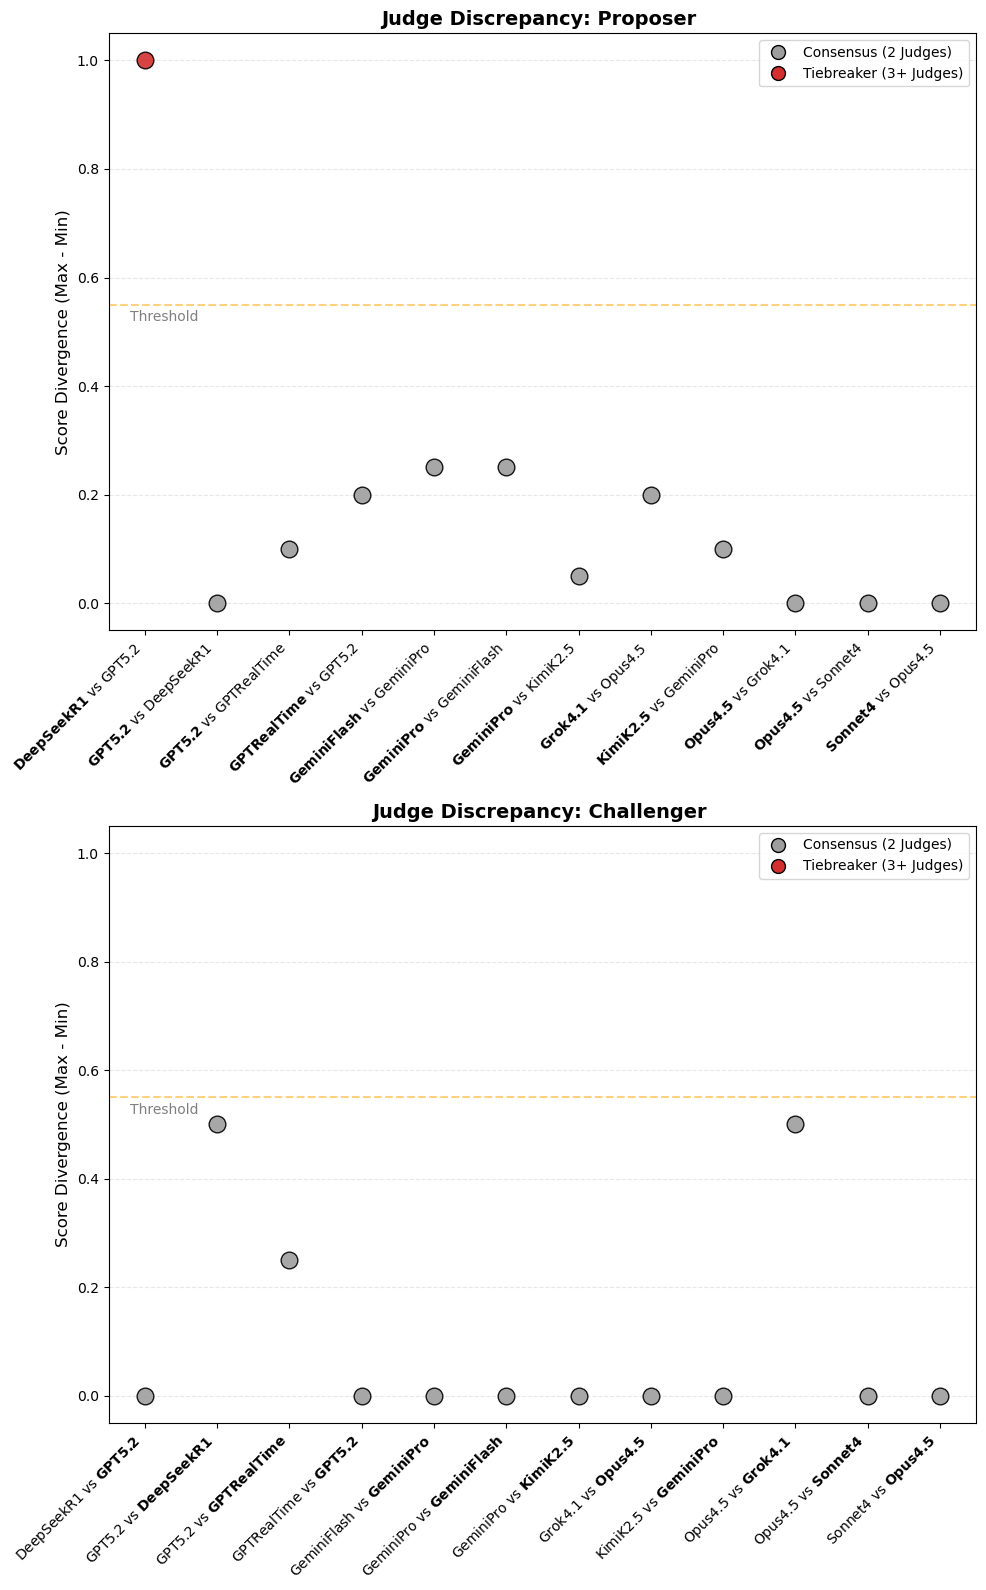

In [6]:
if not df.empty:
    # Group by pairing and role
    judge_stats = df.groupby(["pairing", "role"])["overall_position_alignment"].agg(
        score_min="min",
        score_max="max",
        judge_count="count"
    ).reset_index()

    #Calculate discrepancy & tiebreaker status
    judge_stats["discrepancy"] = judge_stats["score_max"] - judge_stats["score_min"]
    
    # If more than 2 judges were used, it implies a tiebreaker was needed

    judge_stats["tiebreaker_needed"] = judge_stats["judge_count"] > 2

    def create_bold_label(row):
        try:
            p_str = str(row["pairing"])
            if "_vs_" in p_str:
                parts = p_str.split("_vs_")
                # Escape underscores for LaTeX
                p1 = parts[0].strip().replace("_", r"\_")
                p2 = parts[1].strip().replace("_", r"\_")
                
                # Escape spaces for mathtext
                p1 = p1.replace(" ", r"\ ")
                p2 = p2.replace(" ", r"\ ")

                if row["role"] == "Proposer":
                    # Bold the Proposer
                    return r"$\bf{" + p1 + "}$ vs " + p2
                elif row["role"] == "Challenger":
                    # Bold the Challenger
                    return p1 + " vs " + r"$\bf{" + p2 + "}$"
            return p_str
        except:
            return str(row["pairing"])

    judge_stats["plot_label"] = judge_stats.apply(create_bold_label, axis=1)
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 16))
    palette = {False: "#9E9E9E", True: "#D32F2F"}

    def plot_role(role_name, ax):
        subset = judge_stats[judge_stats["role"] == role_name].copy()
        if subset.empty: return

        subset = subset.sort_values("pairing")
        x_order = subset["plot_label"].unique()
        
        sns.stripplot(
            data=subset, 
            x="plot_label", 
            y="discrepancy", 
            hue="tiebreaker_needed", 
            palette=palette,
            size=12, 
            alpha=0.9, 
            jitter=False,
            edgecolor="black", 
            linewidth=1,
            ax=ax,
            order=x_order
        )
        

        ax.set_title(f"Judge Discrepancy: {role_name} ", fontsize=14, fontweight='bold')
        ax.set_ylabel("Score Divergence (Max - Min)", fontsize='large')
        ax.set_xlabel("") # Hide redundant x-label
        ax.grid(axis='y', linestyle='--', alpha=0.3)

        ax.set_ylim(-0.05, 1.05)

        ax.axhline(0.55, color='orange', linestyle='--', alpha=0.5, label="Threshold (0.5)")

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.text(-0.2,0.52,'Threshold', fontsize='medium',alpha=0.5)

        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='Consensus (2 Judges)', 
                   markerfacecolor='#9E9E9E', markersize=10, markeredgecolor='k'),
            Line2D([0], [0], marker='o', color='w', label='Tiebreaker (3+ Judges)', 
                   markerfacecolor='#D32F2F', markersize=10, markeredgecolor='k')
        ]
        ax.legend(handles=legend_elements, loc='upper right')


    
    plot_role("Proposer", axes[0])
    plot_role("Challenger", axes[1])

    plt.tight_layout()
    plt.savefig("judge_discrepancy_split_bold.png", bbox_inches='tight')
    plt.show()
